Kawasaki Quantum Summer Camp 2024

# 量子テレポーテーション：解答例


Kifumi Numata, IBM Quantum (Jul 31, 2024)

In [1]:
# Qiskitライブラリーを導入
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.result import marginal_counts

import numpy as np

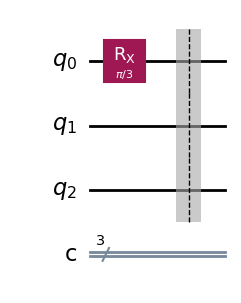

In [2]:
# 3量子ビット回路を用意
qc = QuantumCircuit(3,3)    

# Aliceのもつ暗号の量子状態ψを今回はRxで作ります
qc.rx(np.pi/3,0)
qc.barrier()    #回路を見やすくするために入れます

# 回路を描画
qc.draw(output="mpl")

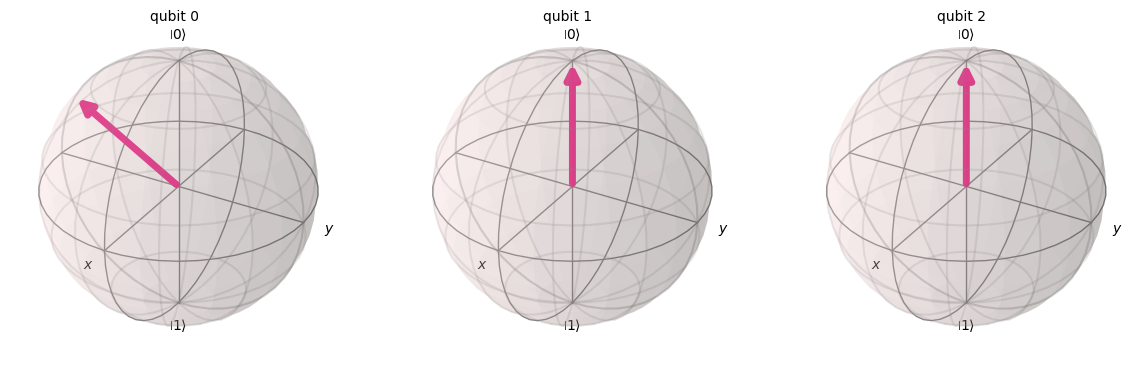

In [3]:
backend = StatevectorSimulator()
out_vector = backend.run(qc, shots=1).result().get_statevector() # set shots = 1

plot_bloch_multivector(out_vector)

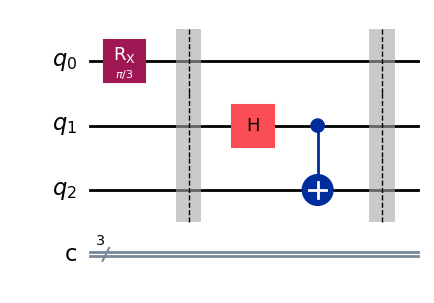

In [4]:
# 量子もつれを作ります
qc.h(1)
qc.cx(1, 2)
qc.barrier()    #回路を見やすくするために入れます

# 回路を描画
qc.draw(output="mpl")

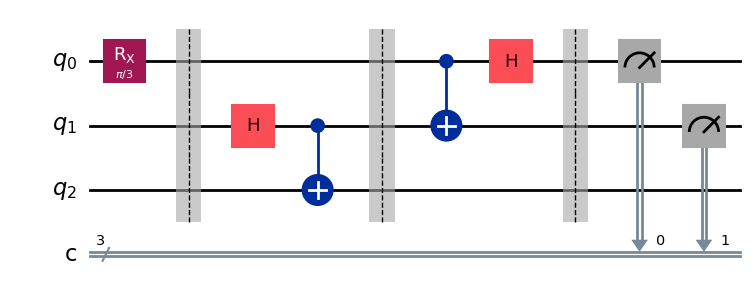

In [5]:
# AliceがCNOTとHで、自分の量子ビット2つをエンタングルさせ測定します。
qc.cx(0, 1)
qc.h(0)
qc.barrier()
qc.measure(0, 0)
qc.measure(1, 1)

# 回路を描画
qc.draw(output="mpl")

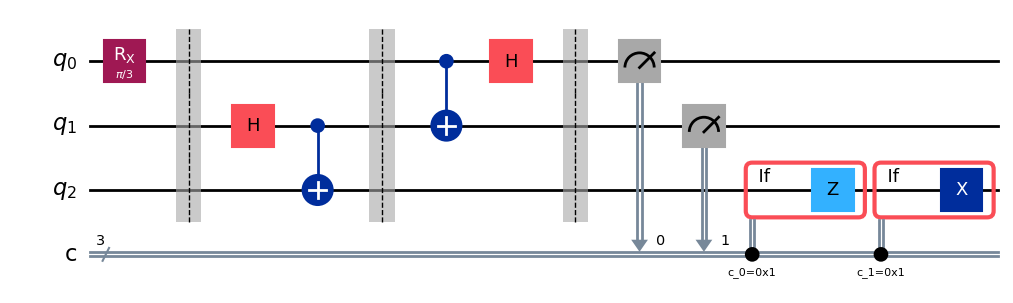

In [6]:
#Aliceが測定結果をBobに送り、Bobが結果に合わせて操作します
with qc.if_test((0, 1)): # 古典レジスター0の値が1だったらZゲートをq2にかける
    qc.z(2)
with qc.if_test((1, 1)): # 古典レジスター1の値が1だったらXゲートをq2にかける
    qc.x(2)
    
qc.draw(output="mpl")

量子テレポーテーション回路が完成しました。qubit2にqubit0の量子状態($R_x(\pi/3)$)が転送されていることを確認しましょう。

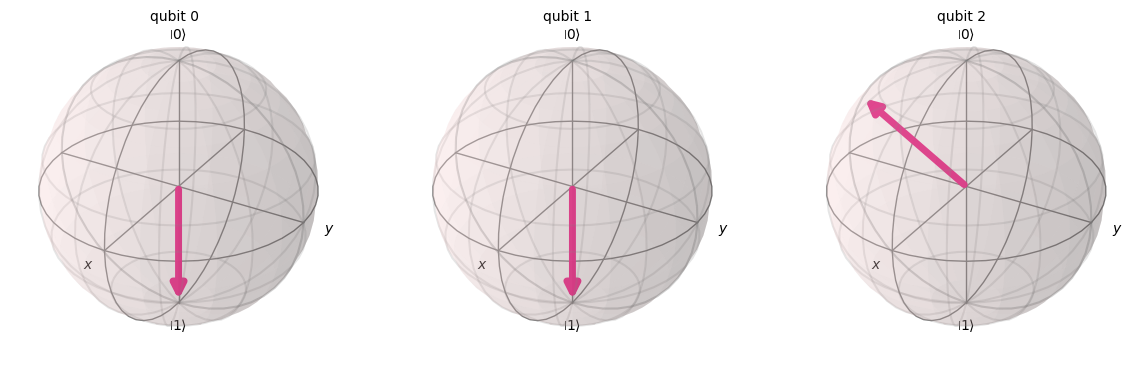

In [7]:
backend = StatevectorSimulator()
out_vector = backend.run(qc,shots=1).result().get_statevector()

plot_bloch_multivector(out_vector)

Bobに暗号の量子状態が転送されたことを確認するために、最後にBobの量子ビットに逆向きのX軸回転を適用して、シミュレーターで実験し、測定結果が0になることを確認します。

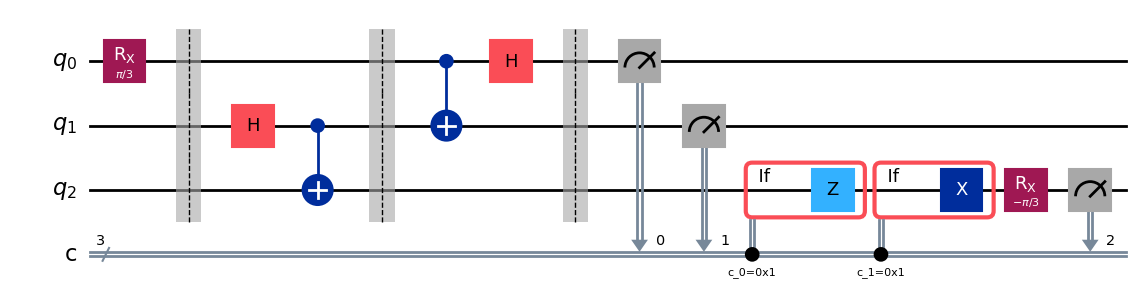

In [8]:
# 3量子ビット回路を用意
qc = QuantumCircuit(3,3)  

# Aliceのもつ未知の量子状態ψをRxで作ります。角度はπ/3にしました。
qc.rx(np.pi/3,0)
qc.barrier()    #回路を見やすくするために入れます

# 量子もつれを作ります
qc.h(1)
qc.cx(1, 2)
qc.barrier()

# AliceがCNOTとHで自分の量子ビット2つをエンタングルさせ測定します。
qc.cx(0, 1)
qc.h(0)
qc.barrier()
qc.measure(0, 0)
qc.measure(1, 1)

#Aliceが測定結果をBobに送り、Bobが結果に合わせて操作します
with qc.if_test((0, 1)): # 古典レジスター0の値が1だったらZゲートをq2にかける
    qc.z(2)
with qc.if_test((1, 1)): # 古典レジスター1の値が1だったらXゲートをq2にかける
    qc.x(2)

# 未知の量子状態ψの逆ゲートをかけて０が測定できるか確かめます
qc.rx(-np.pi/3, 2)    
qc.measure(2, 2)

qc.draw(output="mpl")

{'010': 246, '001': 265, '011': 269, '000': 244}


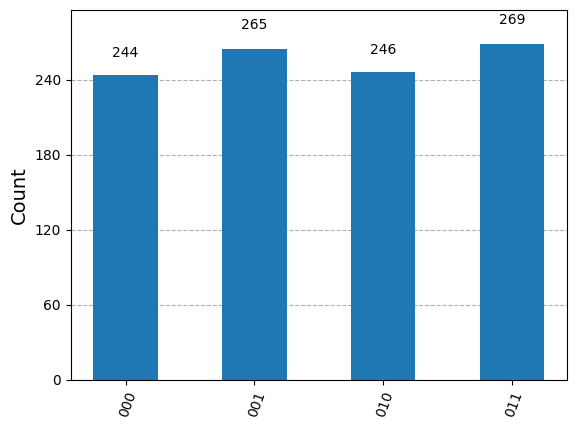

In [9]:
# シミュレーターで実験
backend = AerSimulator()

# Samplerで実行
sampler = SamplerV2(backend)
job = sampler.run([qc])
result = job.result()


#  測定された回数を表示
counts = result[0].data.c.get_counts()
print(counts)

# ヒストグラムで測定された確率をプロット
plot_histogram(counts)

qiskitのビット配列は右端が0なので、Bobのビット(qubit 2)は左端です。左端のビットが全て0になっていることが確認できましたか？

## 実デバイスでの実行

実デバイスで上記の実験を行ってみましょう。（量子計算の途中の測定結果を使ってさらに計算を続ける「動的回路」は、昨年末に実装されたばかりの新機能です！）

In [10]:
# アカウント情報をロードして、使える量子デバイスを確認します
# service = QiskitRuntimeService(instance='ibm-q/open/main')
service = QiskitRuntimeService()
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_cusco')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_nazca')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_torino')>]

In [11]:
# 以下でデバイスを指定できます。
backend = service.get_backend('ibm_brisbane')

/var/folders/z_/wh262lbd0y3525732h4t_4d00000gn/T/ipykernel_3383/3037952693.py:2: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = service.get_backend('ibm_brisbane')


In [23]:
#一番空いているバックエンドを自動的に選択することもできます
backend = service.least_busy(operational=True)
print("最も空いているバックエンドは: ", backend)

最も空いているバックエンドは:  <IBMBackend('ibm_osaka')>


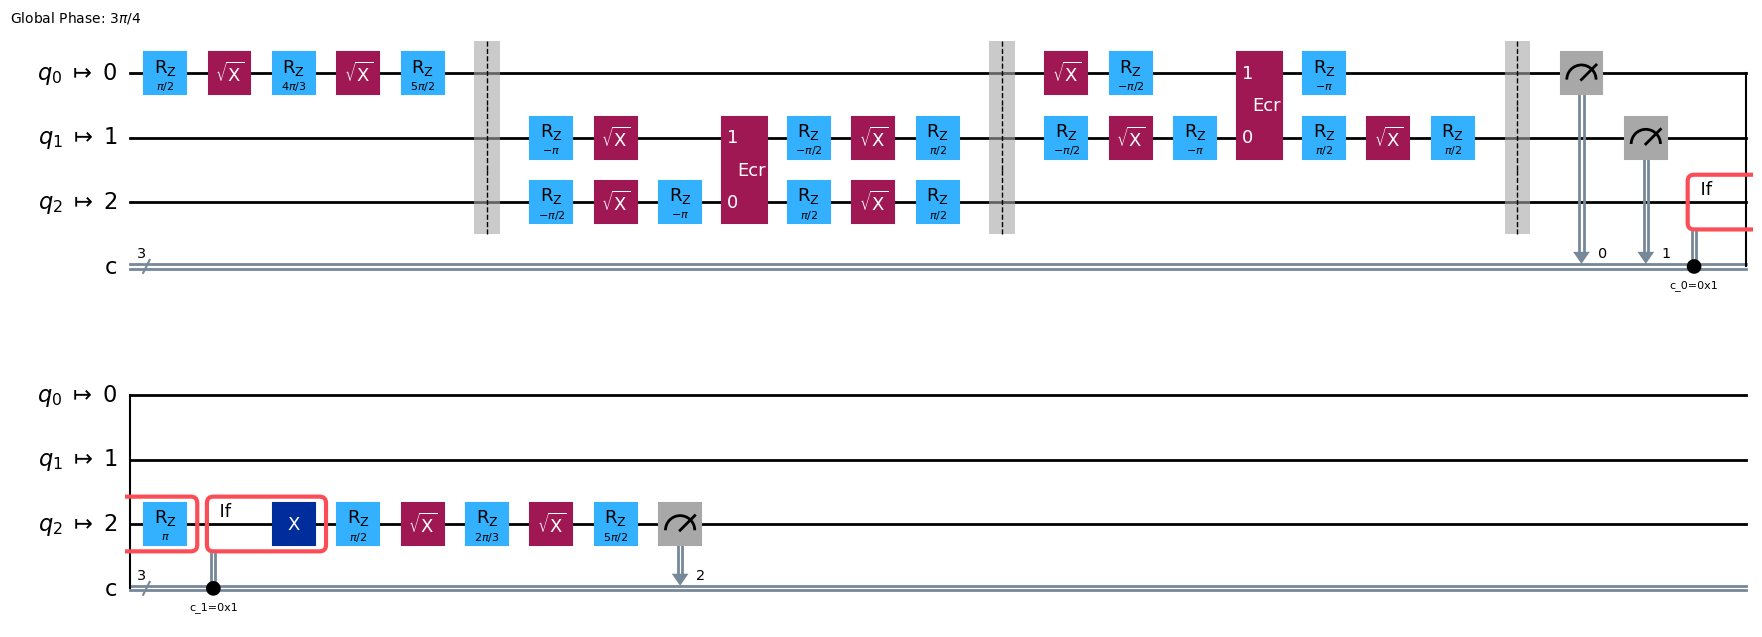

In [12]:
# 回路を実機のバックエンドでの実行に最適な回路に変換します
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

In [13]:
# Samplerで実行します
sampler = SamplerV2(backend)
job = sampler.run([isa_circuit])

print("job id:", job.job_id()) # job idの確認

job id: cta7j9hcvhg0008wwpq0


In [16]:
# ジョブの実行状態を確認します
job = service.job(job.job_id())
job.status()

'DONE'

'DONE' と表示されたら、以下で結果を確認します。

In [17]:
### DONEになってから実行します ###
result = job.result()
print(f" > Counts: {result[0].data.c.get_counts()}")

 > Counts: {'011': 764, '000': 802, '001': 925, '100': 108, '111': 382, '010': 646, '110': 308, '101': 161}


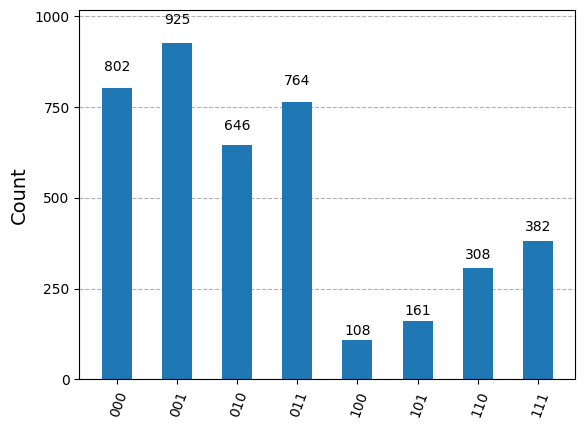

In [18]:
plot_histogram(result[0].data.c.get_counts())

Qiskitのビット配列は右端が0なので、Bobのビット(qubit 2)は左端です。Bobのビットの結果のみ抜き出します。

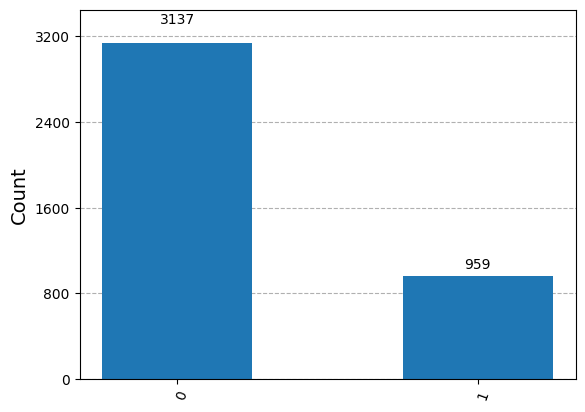

In [20]:
from qiskit.result import marginal_counts
bobs_qubit = 2
bobs_counts = marginal_counts(result[0].data.c.get_counts(), [bobs_qubit])
plot_histogram(bobs_counts)

## 演習

量子テレポーテーション回路を自分で組んで表示してみましょう。<br>
今回は、未知の量子状態をY軸回転ゲート(`ry`を使います。角度は自由に決めます。)で作ってみましょう。<br>
Bobに未知の量子状態が転送されたことを確認するために、最後にBobの量子ビットに逆向きのY軸回転(角度にマイナスをつけます)を適用して、シミュレーターで実験し、測定結果が0になることを確認しましょう。

時間に余裕がある方は、実デバイスでも上記の実験を行ってみましょう。

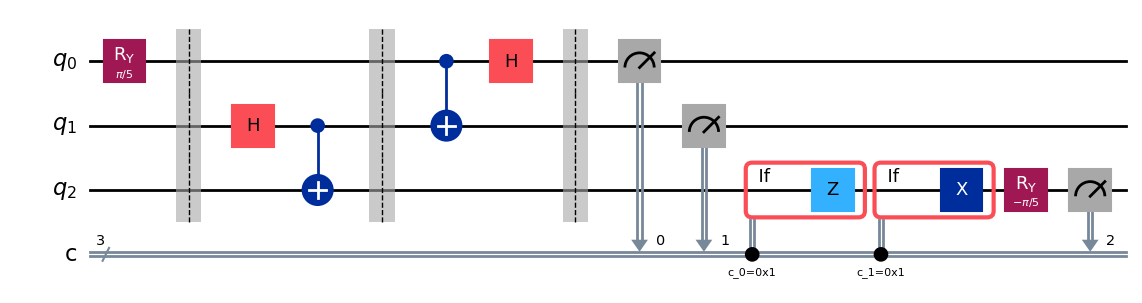

In [2]:
# 3量子ビット回路を用意
qc = QuantumCircuit(3,3)    

##量子テレポーテーションのコードを作ってください##
# Aliceのもつ未知の量子状態ψをRyで作ります。
qc.ry(np.pi/5,0) #角度はπ/5にしました
qc.barrier()    #回路を見やすくするために入れます

# 量子もつれを作ります
qc.h(1)
qc.cx(1, 2)
qc.barrier()

# AliceがCNOTとHでψと自分のEPRペアをエンタングルさせ測定します。
qc.cx(0, 1)
qc.h(0)
qc.barrier()
qc.measure(0, 0)
qc.measure(1, 1)

#Aliceが測定結果をBobに送り、Bobが結果に合わせて操作します
with qc.if_test((0, 1)): # 古典レジスター0の値が1だったらZゲートをq2にかける
    qc.z(2)
with qc.if_test((1, 1)): # 古典レジスター1の値が1だったらXゲートをq2にかける
    qc.x(2)
    
# 未知の量子状態ψの逆向きの演算をかけて０が測定できるか確かめます
qc.ry(-np.pi/5, 2)    
qc.measure(2, 2)

# 回路を描画
qc.draw(output="mpl")

{'011': 242, '000': 258, '001': 277, '010': 247}


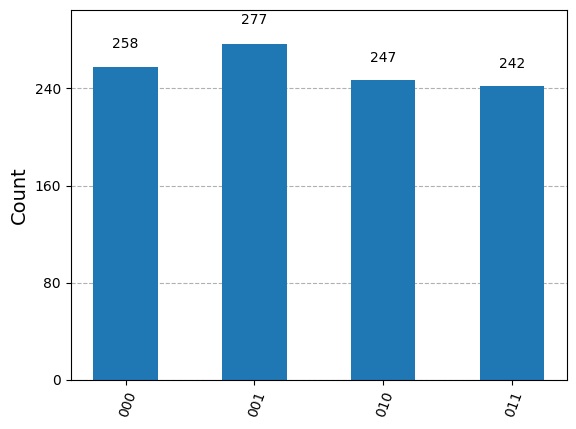

In [3]:
# シミュレーターで実験の際に使うコード例
backend = AerSimulator()

# Samplerで実行
sampler = SamplerV2(backend)
job = sampler.run([qc])
result = job.result()

#  測定された回数を表示
counts = result[0].data.c.get_counts()
print(counts)

# ヒストグラムで測定された確率をプロット
plot_histogram(counts)

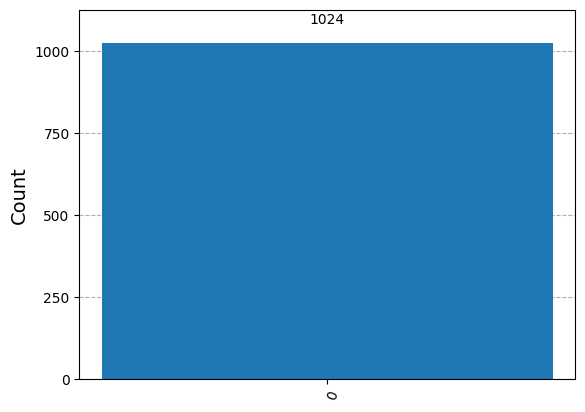

In [4]:
# Bobのビットの結果のみ抜き出します
bobs_qubit = 2
bobs_counts = marginal_counts(result[0].data.c.get_counts(), [bobs_qubit])
plot_histogram(bobs_counts)

In [5]:
import qiskit
qiskit.__version__

'1.1.1'